# Misinformation Game Logo

This notebook contains code to generate the Misinformation Game's logo.

In [1]:
from PIL import Image


# The width and height of the generated logo-full.png
width = 512 # 1024

# A multiplier for the size of the image to help with anti-aliasing.
super_sampling = 4 # 8

# The width of the image with super-sampling.
ss_width = width * super_sampling

# The number of points around the circle.
point_count = 8

# The method to use when downsizing the logo.
resampling_method = Image.Resampling.LANCZOS

## Logo Generation

In [2]:
from typing import Optional
import pathlib
import math
import numpy as np
from PIL import ImageDraw


def gen_logo(*, connected_points: Optional[dict[tuple[int, int], float]] = None):
    # Generate the outer circle of the logo.
    logo = Image.new("RGBA", (ss_width, ss_width))
    logo_draw = ImageDraw.Draw(logo)
    outer_width = int(0.025 * ss_width)
    offset = outer_width
    circle_bounds = [(offset, offset), (ss_width - 1 - offset, ss_width - 1 - offset)]
    logo_draw.ellipse(circle_bounds, fill="#FFFFFF")

    # Generate the mask representing the circle of the logo.
    # This is used to remove the ends of lines that extend over the circle.
    mask = Image.new("L", (ss_width, ss_width), color=0)
    mask_draw = ImageDraw.Draw(mask)
    mask_draw.ellipse(circle_bounds, fill=255)

    # Generate the points around the circle to connect.
    radius = (ss_width - 2 * outer_width) / 2
    centre_x, centre_y = ss_width // 2, ss_width // 2
    d2r = 2.0 * math.pi / 360.0
    points = [(
        centre_x + radius * math.cos(a * d2r),
        centre_y + radius * math.sin(a * d2r)
    ) for a in range(0, 360, 360 // point_count)]

    # By default, draw all lines.
    if connected_points is None:
        connected_points = {}
        for i1 in range(len(points)):
            for i2 in range(len(points)):
                if i2 > i1:
                    connected_points[(i1, i2)] = 1.0

    # We always want to generate the lines between adjacent points.
    for index in range(len(points)):
        connected_points[(index, (index + 1) % len(points))] = 1.0

    # Generate the lines between points on the circle.
    base_line_width = int(0.025 * ss_width)
    for (i1, i2), progress in connected_points.items():
        if progress <= 0:
            continue

        p1, p2 = points[i1], points[i2]
        dx, dy = p2[0] - p1[0], p2[1] - p1[1]
        p3 = p1[0] + progress * dx, p1[1] + progress * dy

        # Longer lines are made thicker.
        dist = math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
        line_width = base_line_width + int(0.05 * max(0, dist - 1.5 * radius))
        logo_draw.line([p1, p3], fill="#000000", width=line_width)


    # Remove white on the outsides of the logo.
    pixels = np.array(logo)
    mask_pixels = np.array(mask)
    for row in range(ss_width):
        row_pixels = pixels[row]
        row_mask_pixels = mask_pixels[row]
        black_pixels = ((row_pixels[:, 0] == 0) &
                       (row_pixels[:, 1] == 0) &
                       (row_pixels[:, 2] == 0) &
                       (row_pixels[:, 3] == 255))

        start = np.argmax(black_pixels)
        end = len(black_pixels) - 1 - np.argmax(black_pixels[::-1])
        if start < end:
            row_mask_pixels[:start] = 0
            row_mask_pixels[end:] = 0

    mask = Image.fromarray(mask_pixels, "L")
    mask_draw = ImageDraw.Draw(mask)

    # Smooth out the corners of the logo.
    for index, point in enumerate(points):
        x, y = point

        # Calculate the direction towards the centre of the logo.
        dx, dy = centre_x - x, centre_y - y
        dl = math.sqrt(dx**2 + dy**2)
        ux, uy = dx / dl, dy / dl

        # Calculate the angle to the points that are to the left and right of this point.
        left_x, left_y = points[(index - 1) % len(points)]
        right_x, right_y = points[(index + 1) % len(points)]
        left_angle = math.atan2(left_y - y, left_x - x)
        right_angle = math.atan2(right_y - y, right_x - x)

        # Calculate the points that we want to draw an arc between.
        radius = 0.1 * ss_width
        left_from_x, left_from_y = (
            x + radius * math.cos(left_angle),
            y + radius * math.sin(left_angle)
        )
        right_from_x, right_from_y = (
            x + radius * math.cos(right_angle),
            y + radius * math.sin(right_angle)
        )

        # Calculate the centre of the circle to draw the arc.
        left_angle -= math.pi / 2
        right_angle += math.pi / 2

        d_sin = math.sin(right_angle) - math.sin(left_angle)
        d_cos = math.cos(right_angle) - math.cos(left_angle)
        if abs(d_sin) > abs(d_cos):
            t = (left_from_y - right_from_y) / d_sin
        else:
            t = (left_from_x - right_from_x) / d_cos

        circle_centre_x = left_from_x + math.cos(left_angle) * t
        circle_centre_y = left_from_y + math.sin(left_angle) * t
        circle_radius = abs(t)

        # Draw the arc, offset so that it lines up with the lines between the points.
        line_width = int(0.02 * ss_width)
        dx, dy = -1.75 * ux * line_width, -1.75 * uy * line_width
        mask_draw.arc(
            [
                (int(circle_centre_x - circle_radius + dx),
                 int(circle_centre_y - circle_radius + dy)),

                (int(circle_centre_x + circle_radius + dx),
                 int(circle_centre_y + circle_radius + dy))
            ],
            (left_angle / d2r + 540) % 360,
            (right_angle / d2r + 540) % 360,
            fill=0,
            width=line_width
        )

        inside_edge_radius = circle_radius - 1.28 * line_width
        logo_draw.arc(
            [
                (int(circle_centre_x - inside_edge_radius + dx),
                 int(circle_centre_y - inside_edge_radius + dy)),

                (int(circle_centre_x + inside_edge_radius + dx),
                 int(circle_centre_y + inside_edge_radius + dy))
            ],
            (left_angle / d2r + 540) % 360,
            (right_angle / d2r + 540) % 360,
            fill=(0, 0, 0, 0),
            width=line_width
        )

    # Apply the mask.
    logo.putalpha(mask)
    return logo


## Test the Border of the Logo

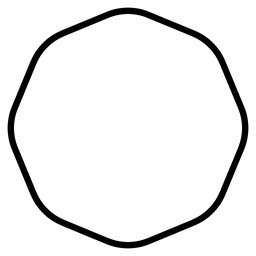

In [3]:
logo_border = gen_logo(connected_points={})
logo_border.resize((256, 256), resample=resampling_method)

## Generate the Full Logo

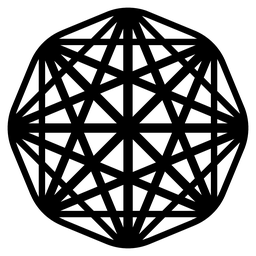

In [4]:
logo = gen_logo()

# Resize the super-sampled logo back to the target width.
logo_full = logo.resize((width, width), resample=resampling_method)
pathlib.Path("out").mkdir(exist_ok=True)
logo_full.save("out/logo-full.png")

logo.resize((256, 256), resample=resampling_method)

## Size Previews

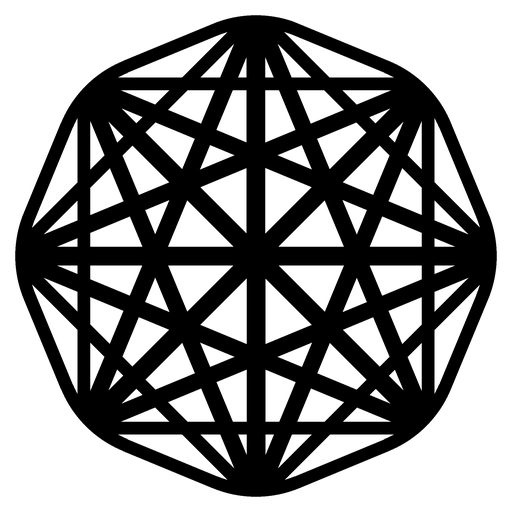

In [5]:
logo_large = logo.resize((512, 512), resample=resampling_method)
logo_large.save("out/logo-large.png")
logo_large

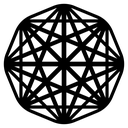

In [6]:
logo_medium = logo.resize((128, 128), resample=resampling_method)
logo_medium.save("out/logo-medium.png")
logo_medium

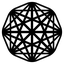

In [7]:
logo_small = logo.resize((64, 64), resample=resampling_method)
logo_small.save("out/logo-small.png")
logo_small

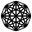

In [8]:
logo_tiny = logo.resize((32, 32), resample=resampling_method)
logo_tiny.save("out/logo-tiny.png")
logo_tiny

## Animation

In [68]:
# The order of lines to appear.
anim_line_order = [
    (0, 2), (1, 3), (2, 4), (3, 5), (4, 6), (5, 7), (6, 0), (7, 1),
    (0, 3), (1, 4), (2, 5), (3, 6), (4, 7), (5, 0), (6, 1), (7, 2),
    (0, 4), (1, 5), (2, 6), (3, 7), (4, 0), (5, 1), (6, 2), (7, 3),
]

# The duration between revealing lines.
anim_line_interval_seconds = 0.1

# The time taken to reveal each line.
anim_line_duration_seconds = 0.2

# The frames per second to generate for the animation.
anim_fps = 60

# The width of the video frames
anim_width = 512

# The time to freeze at the end of the animation.
anim_freeze_duration_seconds = 1.0


In [69]:
anim_line_interval = int(anim_fps * anim_line_interval_seconds)
anim_line_duration = int(anim_fps * anim_line_duration_seconds)
anim_freeze_duration = int(anim_fps * anim_freeze_duration_seconds)
anim_duration = len(anim_line_order) * anim_line_interval + \
                anim_line_duration + anim_freeze_duration

In [74]:
from tqdm import tqdm

frames = []

for frame_no in tqdm(range(anim_duration)):
    revealed_lines = frame_no // anim_line_interval
    connected_points = {}
    for line_index, line in enumerate(anim_line_order[:revealed_lines]):
        reveal_frame = anim_line_interval * (line_index + 1)
        frames_since_reveal = frame_no - reveal_frame
        progress = min(1.0, frames_since_reveal / anim_line_duration * (1 + line_index / 20))
        connected_points[line] = progress

    logo_frame = gen_logo(connected_points=connected_points)
    logo_frame = logo_frame.resize((anim_width, anim_width), resample=resampling_method)

    # Introduce a green background for saving as a video.
    background = Image.new("RGBA", logo_frame.size, (230, 230, 230))
    alpha_composite = Image.alpha_composite(background, logo_frame)
    frames.append(alpha_composite.convert('RGB'))


100%|██████████| 216/216 [00:27<00:00,  7.86it/s]


In [75]:
import cv2

writer = cv2.VideoWriter(
    "out/animation.mp4",
    cv2.VideoWriter_fourcc(*"avc1"),
    anim_fps,
    (anim_width, anim_width)
)
for frame in frames:
    writer.write(np.array(frame)[:, :, ::-1])

writer.release()